# Setup

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import os
import itertools
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn
import mpl_toolkits.axisartist as axisartist
from typing import Dict, List, Optional, Tuple, NamedTuple, Sequence, Union, Any
import pandas as pd
import os.path as osp
from pathlib import Path
import glob
import re
from collections import defaultdict
import scipy
from tqdm import tqdm
import pickle
from typing import NamedTuple
import time
import json



def setup_style():
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    LARGE_SIZE = 18

    # General configuration: https://matplotlib.org/stable/api/matplotlib_configuration_api.html#default-values-and-styling
    # Default rcParams: https://matplotlib.org/stable/tutorials/introductory/customizing.html#the-default-matplotlibrc-file
    # plt.rc vs plt.rcParams: TLDR: plt.rc updates plt.rcParams: https://stackoverflow.com/questions/67148006/what-is-the-difference-between-matplotlib-rc-and-matplotlib-rcparams-and-wh

    # Style-sheets: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
    # plt.style.use('bmh')
    
    seaborn.set_style("whitegrid", {'grid.linestyle': '--'})
    seaborn.set_palette('colorblind')
    # plt.style.use('tableau-colorblind10')
    # You don't need latex: https://matplotlib.org/3.5.0/tutorials/text/mathtext.html
    # plt.rc('text', usetex=True)
    # Font: https://matplotlib.org/stable/tutorials/text/text_props.html#default-font
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.sans-serif'] = ['Dejavu Sans', 'Computer Modern Sans Serif', 'Helvetica',  'sans-serif']  # first one will be used. Dejavu is just the default
    plt.rcParams['font.serif'] = ['Liberation Serif', 'Computer Modern Roman', 'Times New Roman', 'serif']
    plt.rcParams['font.weight'] = 'normal'  # or light, bold
    plt.rcParams['font.size'] = SMALL_SIZE
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams['axes.titlesize'] = MEDIUM_SIZE  # fontsize of the axes title
    plt.rcParams['axes.labelsize'] = SMALL_SIZE  # fontsize of the x and y labels
    plt.rcParams["axes.grid"] = True
    plt.rcParams['axes.formatter.useoffset'] = False  # Don't offset. See https://matplotlib.org/stable/api/ticker_api.html#matplotlib.ticker.ScalarFormatter.set_useOffset
    plt.rcParams['figure.dpi'] = 300  # default is 100

    plt.rcParams['xtick.labelsize'] = SMALL_SIZE  # fontsize of the tick labels
    plt.rcParams['ytick.labelsize'] = SMALL_SIZE  # fontsize of the tick labels

    plt.rcParams['legend.fontsize'] = SMALL_SIZE  # legend fontsize
    plt.rcParams['figure.titlesize'] = MEDIUM_SIZE  # fontsize of the figure title
    plt.rcParams['lines.linewidth'] = 1.5

    # Color cycle
    # Specifying colors: https://matplotlib.org/3.1.0/tutorials/colors/colors.html
    # Specifying line styles: https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/linestyles.html
    # Cycler: https://matplotlib.org/stable/tutorials/intermediate/color_cycle.html
    from cycler import cycler
    # prop_cycle = cycler(color=['r', 'g', 'b', 'y']) + cycler(linestyle=['-', '--', ':', '-.'])
    # prop_cycle = cycler(color=['tab:red', 'tab:green', 'tab:blue']) * cycler(linestyle=['-', '--', ':', '-.'])
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    prop_cycle = plt.rcParams['axes.prop_cycle']  # The default one
    plt.rcParams['axes.prop_cycle'] = prop_cycle

setup_style()


nested_dict = lambda: defaultdict(nested_dict)
def construct_varying_keys(grids):
    all_keys = set().union(*[g.keys() for g in grids])
    merged = {k: set() for k in all_keys}
    for grid in grids:
        for key in all_keys:
            grid_key_value = grid[key] if key in grid else ["<<NONE>>"]
            merged[key] = merged[key].union(grid_key_value)
    #varying_keys = {key for key in merged if len(merged[key]) > 1}
    varying_keys = {key for key in merged}
    return varying_keys


def construct_jobs(grids: List[Dict[str, List[Any]]]) -> List[Dict[str, Any]]:
    """Construct a list of jobs."""
    jobs = []
    for grid in grids:
        """
        {
            'a': [1, 2],
            'b': [3, 4]
        }
        -->
        {
            [{'a': 1}, {'a': 2}],
            [{'b': 3}, {'b': 4}],
        }
        """
        individual_options = [[{key: value} for value in values]
                              for key, values in grid.items()]
        product_options = list(itertools.product(*individual_options))
        """
        [
            {'a': 1, 'b': 3},
            {'a': 1, 'b': 4},
            {'a': 2, 'b': 3},
            {'a': 2, 'b': 4},
        ]
        """
        jobs += [{k: v for d in option_set for k, v in d.items()}
                 for option_set in product_options]
    return jobs


def construct_flag_string(job):
    """construct the string of arguments to be passed to the script"""
    flagstring = ""
    for flag in job:
        if isinstance(job[flag], bool):
            if flag.startswith('--'):
                raise ValueError('No supported yet')
            else:
                flagstring = flagstring + " " + flag + "=" + str(job[flag])

            # if job[flag]:
                # flagstring = flagstring + " --" + flag
            # else:
                # flagstring = flagstring + " --" + 'no' + flag
                # print("WARNING: Excluding 'False' flag " + flag)
        else:
            if not flag.startswith('--'):
                flagstring = flagstring + " " + flag + "=" + str(job[flag])
            else:
                flagstring = flagstring + " " + flag + " " + str(job[flag])
    return flagstring

def construct_name(job, varying_keys):
    """construct the job's name out of the varying keys in this sweep"""
    varying_keys = [key for key in varying_keys if 'config_path' not in key]
    return '_'.join(['{}_{}'.format(flag.strip('-'), str(job[flag]))
        for flag in job if flag in varying_keys])

def crop_runs(df: pd.DataFrame, step: int):
    def crop(run: pd.Series):
        indices = run['step'] <= step
        run['step'] = run['step'][indices]
        run['return'] = run['return'][indices]
        return run
    return df.transform(crop, axis=1)

def drop_short_runs(df: pd.DataFrame, step: Optional[int] = None):
    def check_length(run: pd.Series):
        nonlocal step
        step = step if step is not None else run['train_evaluation.n_iters']
        max_step = run['epoch'][-1] 
        if max_step < step:
            print(f'Dropping short run {run["jobname"]}, seed {run["seed"]}. Only {max_step}/{step} steps found.')
            return False
        else:
            return True
    return df[df.apply(check_length, axis=1)]
def get_stat(df: pd.DataFrame, key: str, step: Optional[int] = None, mode: str = 'best', rank: int = 0):
    assert mode == 'avg' or mode == 'raw'
    def get_score(run: pd.Series):
        if step is not None:
            if run['step'][-1] < step:
                print(f'WARNING, too short results for {run["jobname"]}, seed {run["seed"]}. only {run["step"][-1]}/{step} found.')
            try:
                index = np.where(run['step'] <= step)[0][-1]
                if 'daq' in run['config']:
                    if mode == 'raw':
                        score = run[key][index]
                    elif mode == 'best':
                        select_index = np.argmax([run[f'return_select_{i}'] for i in range(int(run['config.n']))])
                        score = run[f'return_actual_{select_index}']
                    elif mode == 'avg':
                        # if hasattr(run, 'return_0'):
                        #     score = np.mean([run[f'return_{i}'] for i in range(int(run['config.n']))])
                        # else:
                        # score = np.mean([run[f'return_select_{i}'] for i in range(int(run['config.n']))])
                        score = np.mean([run[f'{key}_{i}'][index] for i in range(int(run['config.n']))])
                    elif mode == 'rank':
                        select_index = np.argsort([run[f'return_select_{i}'] for i in range(int(run['config.n']))])[rank]
                        score = run[f'return_actual_{select_index}']
                    # score = np.max([run[f'return_{i}'][index] for i in range(int(run['config.n']))])
                else:
                    score = run[key][index]
            except:
                print(step, run['step'])
                raise
                # pdb.set_trace()
        else:
            assert False
            print('WARNING: step is None')
            score = run['return'][-1]
        return score
    df_copy = df.copy()
    df_copy['score'] = df.apply(get_score, axis=1)
    return df_copy





def load_data(grid: List[Dict[str, List]], roots: List[Union[str, Path]]):
    roots = [Path(r) for r in roots]

    # A list of dictionaries
    jobs = construct_jobs(rl_grid)
    varying_keys = construct_varying_keys(rl_grid)
    # A list of strings
    jobnames = [construct_name(job, varying_keys) for job in jobs]

    def load_job_data(job: Dict[str, Any], jobname: str) -> Dict[str, np.ndarray]:
        data = {}
        for split in ['val', 'test']:
            valid_paths = []
            for root in roots:
                path = root / jobname / f'{split}_split_metrics.jsonl'
                if path.is_file():
                    valid_paths.append(path)
            if len(valid_paths) == 0:
                print('WARNING: Path not found, skipping job:')
                print(path)
                return None
            elif len(valid_paths) > 1:
                print('WARNING: Multiple paths found, skipping job:')
                for path in valid_paths:
                    print(path)
                return None
            else:
                path = valid_paths[0]
                split_data = defaultdict(list)
                with path.open('r') as f:
                    for line in f:
                        row = json.loads(line)
                        split_data['epoch'].append(row['epoch'])
                        for key in row['metrics']:
                            split_data[key].append(row['metrics'][key])
                assert all(len(entry) == len(split_data['epoch']) for entry in split_data.values()), {k: len(v) for k, v in split_data.items()}
                # TODO
                                # TODO
                                    # TODO
                # There will be repeat, we drop the last row
                split_data = {k: np.array(v[:-1]) for k, v in split_data.items()}
                
                data[split] = split_data
        return data
                        
    rows = []
    for job, jobname in zip(jobs, jobnames):
        job_data: Dict[str, List[Dict[str, Any]]] = load_job_data(job, jobname)
        if job_data is None:
            continue
        # Merge the split dictionary
        # Check epochs
        assert (job_data['test']['epoch'] == job_data['val']['epoch']).all(), f'Test and validacation epoch does not match for {jobname}'

        row = {}
        for split in ['val', 'test']:
            for key, value in job_data[split].items():
                if key == 'epoch':
                    row[key] = value + 1
                else:
                    row[f'{split}/{key}'] = value
        row.update(job)

        rows.append(row)
    
    return pd.DataFrame(rows)
OUT_MILA = '/home/mila/z/zhixuan.lin/scratch/zxlin/out'
OUT_NARVAL = '/home/mila/z/zhixuan.lin/scratch/zxlin/out_narval'
OUT_CEDAR = '/home/mila/z/zhixuan.lin/scratch/zxlin/out_cedar'
OUT_LOCAL = '/Users/lin/Documents/Courses/UdeM/IFT6289/project/out'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pareto plot

## Grid

In [2]:
num_seeds = 5
rl_grid = [
         {
         "--tags": ['ppo_kl_fixed'],
         '--config_path': ['scripts/training/task_configs/imdb_text_continuation/gpt2_ppo_kl_fixed.yml'],
         "alg.args.analytic_kl_grad": [True],
         "alg.kl_div.analytic_kl_reward": [True],
         "alg.kl_div.target_kl": [0.05, 0.1, 0.2, 0.5],
         "train_evaluation.n_iters": [150],
         "--seed": [i for i in range(num_seeds)],
     },
     {
         "--tags": ['ppo_kl_fixed'],
         '--config_path': ['scripts/training/task_configs/imdb_text_continuation/gpt2_ppo_kl_fixed.yml'],
         "alg.args.analytic_kl_grad": [False],
         "alg.kl_div.analytic_kl_reward": [False],
         "alg.kl_div.target_kl": [0.05, 0.1, 0.2, 0.5],
         "train_evaluation.n_iters": [150],
         "--seed": [i for i in range(num_seeds)],
     },
     {
         "--tags": ['ppo_kl_fixed'],
         '--config_path': ['scripts/training/task_configs/imdb_text_continuation/gpt2_ppo_kl_fixed.yml'],
         "alg.args.analytic_kl_grad": [True],
         "alg.kl_div.analytic_kl_reward": [False],
         "alg.kl_div.target_kl": [0.05, 0.1, 0.2, 0.5],
         "train_evaluation.n_iters": [150],
         "--seed": [i for i in range(num_seeds)],
     },
     {
         "--tags": ['ppo_kl_fixed'],
         '--config_path': ['scripts/training/task_configs/imdb_text_continuation/gpt2_ppo_kl_fixed.yml'],
         "alg.args.analytic_kl_grad": [False],
         "alg.kl_div.analytic_kl_reward": [True],
         "alg.kl_div.target_kl": [0.05, 0.1, 0.2, 0.5],
         "train_evaluation.n_iters": [150],
         "--seed": [i for i in range(num_seeds)],
     }

]

## Load data

In [3]:
%%time
data = load_data(rl_grid, roots=[OUT_LOCAL])
data = drop_short_runs(data, step=150)
print(data.shape)

(80, 96)
CPU times: user 216 ms, sys: 48 ms, total: 264 ms
Wall time: 337 ms


## Aggregate

In [4]:
def expand_df(df: pd.DataFrame):
    new_rows = []
    for _, row in df.iterrows():
        for i in range(len(row['epoch'])):
            new_rows.append({key: row[key][i] if isinstance(row[key], np.ndarray) else row[key] for key in row.index})
    return pd.DataFrame(new_rows)

def aggregate_seed(df: pd.DataFrame) -> pd.Series:
    # df: contains seed for multiple
    keys = ['val/semantic/learned_automodel_metric',
            'val/fluency_metrics/perplexity',
            'test/semantic/learned_automodel_metric',
            'test/fluency_metrics/perplexity'
           ]
    # import ipdb; ipdb.set_trace()
    def get_mean(metrics: pd.Series):
        data = np.stack(metrics, axis=0)
        return pd.Series([data.mean(axis=0)])
    
    def get_std(metrics: pd.Series):
        data = np.stack(metrics, axis=0)
        return pd.Series([data.std(axis=0)])
    
    mean = df[keys].apply(get_mean, axis=0)
    mean = mean.iloc[0]
    std = df[keys].apply(get_std, axis=0)
    std = std.iloc[0]
    mean_std = pd.concat([mean, std], keys=['mean', 'std'])

    return mean_std

def find_pareto_front(df: pd.DataFrame):
    def dominate(x: pd.Series, y: pd.Series):
        key_criterions = [
            (('mean', 'val/semantic/learned_automodel_metric'), lambda x, y: x > y),
            (('mean', 'val/fluency_metrics/perplexity'), lambda x, y: x < y)
        ]
        if all(criterion(x[key], y[key]) for key, criterion in key_criterions):
            return True
        else:
            return False 
    front_rows = []
    for index, row in df.iterrows():
        # import ipdb; ipdb.set_trace()
        indices_to_delete = []
        for front_index, front_row in enumerate(front_rows):
            if dominate(front_row, row):
                break
            elif dominate(row, front_row):
                indices_to_delete.append(front_index)
        else:
            # Normally ended
            front_rows.append(row)
        # Remove dominated entries
        for index in reversed(indices_to_delete):
            del front_rows[index]
    return pd.DataFrame(front_rows)


def get_label(run: pd.Series):
    analytic_kl_grad = run['alg.args.analytic_kl_grad']
    analytic_kl_reward = run["alg.kl_div.analytic_kl_reward"]
    
    return (analytic_kl_grad, analytic_kl_reward)

def get_subset(run: pd.Series):
    return True


def get_run_label(run: pd.Series):
    analytic_kl_grad = run['alg.args.analytic_kl_grad']
    analytic_kl_reward = run["alg.kl_div.analytic_kl_reward"]
    target_kl = run['alg.kl_div.target_kl']
    return f'AG={analytic_kl_grad}, AR={analytic_kl_reward}, target KL=${target_kl}$'

# Expand epoch data
data_by_epoch = expand_df(data)
print(data_by_epoch.shape)

# each row: a run, results aggregated from multiple seeds
# index are labels
data_group_by_config = data_by_epoch.groupby(
    ['alg.args.analytic_kl_grad', "alg.kl_div.analytic_kl_reward", 'alg.kl_div.target_kl', 'epoch'])

# for label, group in data_group_by_config:
#     print(label, group.shape)
data_by_run = data_group_by_config.apply(aggregate_seed)
print(data_by_run.index.names, data_by_run.shape)


# Find pareto front for each method
data_group_by_method = data_by_run.groupby(level=['alg.args.analytic_kl_grad', "alg.kl_div.analytic_kl_reward"])
for label, group in data_group_by_method:
    print(label, group.index.names)

pareto_front = data_group_by_method.apply(find_pareto_front)
print(pareto_front.shape)




# print(data_by_epoch.shape)
# print(data_agg_by_run.shape)
# for label, label_data in sorted(data[data.apply(get_subset, axis=1)].groupby(data.apply(get_label, axis=1)), key=lambda x: x[0]):
#     pareto_front
#     combined_score = to_rliable(rr_data)
#     score_dict[(label)] = combined_score
#     print((label), combined_score.shape)
    

# epoch_data = expand_df(data)
# epoch_data.shape
# pareto_front = find_pareto_front(epoch_data)
# print(pareto_front.shape)


(1280, 96)
['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward', 'alg.kl_div.target_kl', 'epoch'] (256, 8)
(False, False) ['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward', 'alg.kl_div.target_kl', 'epoch']
(False, True) ['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward', 'alg.kl_div.target_kl', 'epoch']
(True, False) ['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward', 'alg.kl_div.target_kl', 'epoch']
(True, True) ['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward', 'alg.kl_div.target_kl', 'epoch']
(148, 8)


## Plot

### Validation

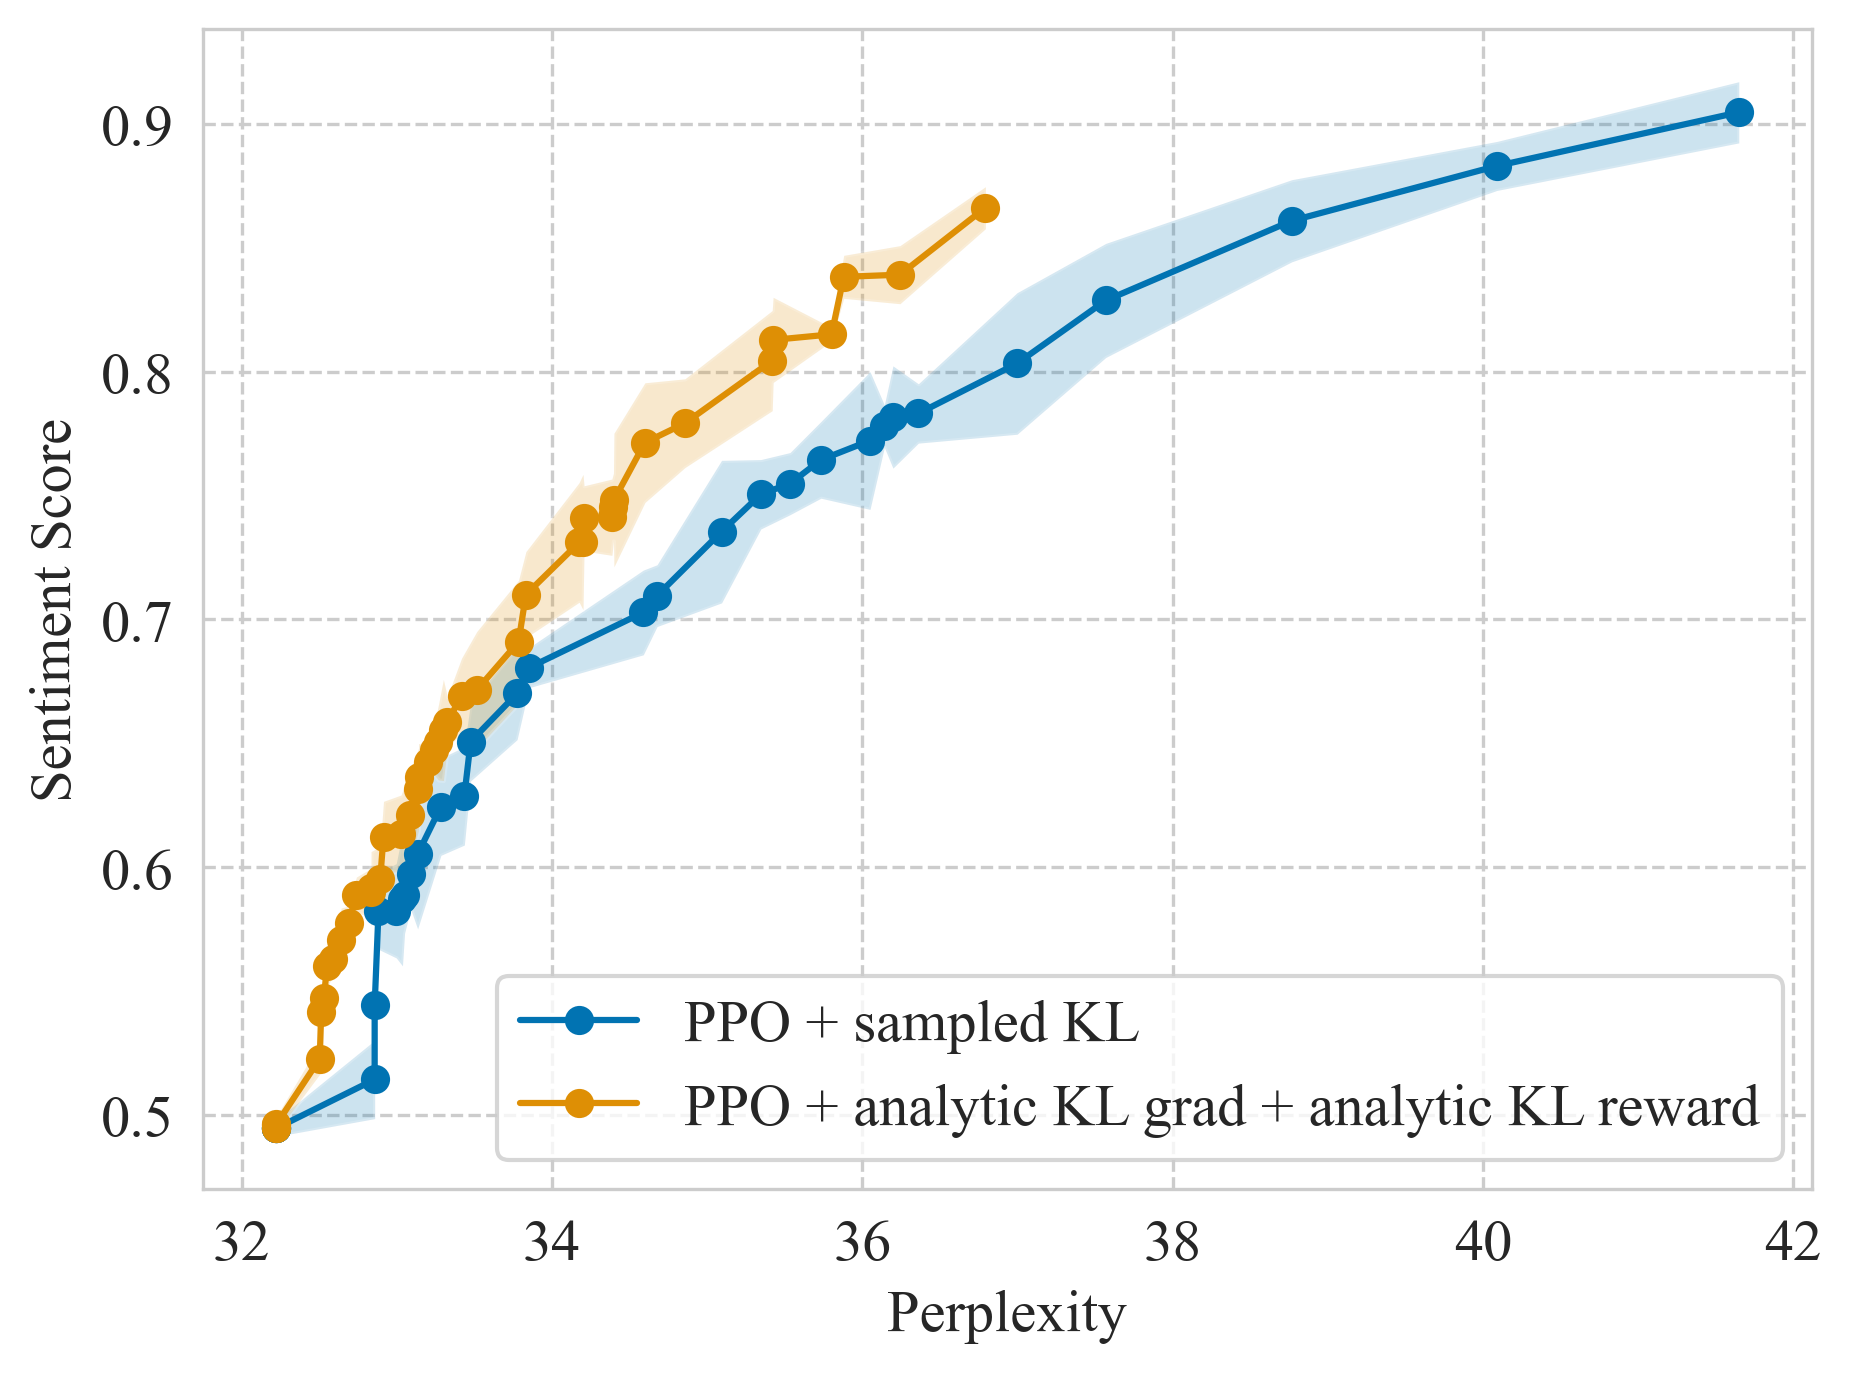

In [68]:
# print(agg_score)
# COLORS = {'SAC + ensemble + resets': 'C3', 'SAC + WD': 'C2', 'SAC + resets': 'C1', 'SAC': 'C0'}
def group_label_to_plot_label(group_label):
    # return f'AG={group_label[0]},AR={group_label[1]}'
    if group_label == (True, True):
        return 'PPO + analytic KL grad + analytic KL reward'
    elif group_label == (False, False):
        return 'PPO + sampled KL'


ncols = 1
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.4 * ncols, 4.8 * nrows), sharey=True, squeeze=False)
ax = axes[0][0]

perplexity_threshold = 100

pareto_front_filtered = pareto_front[pareto_front['mean']['test/fluency_metrics/perplexity'] < perplexity_threshold]

for group_label, group in pareto_front_filtered.groupby(level=['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward']):
    if group_label not in [(True, True), (False, False)]:
        continue
    plot_label = group_label_to_plot_label(group_label)
    split = 'val'
    group = group.sort_values(('mean', f'{split}/fluency_metrics/perplexity'))
    y = group['mean'][f'{split}/semantic/learned_automodel_metric']
    yerr = group['std'][f'{split}/semantic/learned_automodel_metric']
    x = group['mean'][f'{split}/fluency_metrics/perplexity']
    xerr = group['std'][f'{split}/fluency_metrics/perplexity']
    # print(group.shape, group['std'].shape, group['std']['test/semantic/learned_automodel_metric'].shape)
    # print(plot_label, x.shape, y.shape)
    # ax.set_xlim(33, 34)
    # ax.errorbar(x, y, yerr=yerr, marker='', label=plot_label)
    ax.plot(x, y, marker='o', label=plot_label)
    # print(x.shape, y.shape, yerr.shape)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
    ax.set_xlabel('Perplexity')
    ax.set_ylabel('Sentiment Score')
                      
ax.legend()
fig.tight_layout()

# fig, axes = plot_utils.plot_interval_estimates(
#   agg_score_sac_wd_agg, agg_score_cis_sac_wd_agg,
#   # metric_names=['IQM', 'Median', 'Mean'],
#       metric_names=[''],
#   # algorithms=['DrQ + resets, 100K', 'Ours, 100K', 'DrQ + resets, 1M', 'Ours, 1M',], xlabel='IQM',
#     # algorithms=['SAC + ensemble, $N=1$', 'SAC| + ensemble, $N=5$', 'SAC + ensemble, $N=10$', 'SAC + ensemble, $N=20$', ], xlabel='IQM',
#         # algorithms=['SAC + ens. ($N=1$)', 'SAC + ens. ($N=5$)', 'SAC + ens. ($N=10$)', 'SAC + ens. ($N=20$)', ], xlabel='IQM',
#         # colors=COLORS,
#             algorithms=labels, xlabel='IQM',
#     # algorithms=['DrQ, 100K', 'DrQ + resets, 100K', 'Ours, n=10, 100K', 'DrQ, 1M', 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#     # algorithms=[ 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#   row_height=0.7
# )
# # print(agg_score)
# # axes.set_title('SAC + ensemble', fontsize='xx-large')
# # fig.tight_layout()
FIGURE_DIR = Path('/Users/lin/Documents/Courses/UdeM/IFT6289/project/figures/')
os.makedirs(FIGURE_DIR, exist_ok=True)
BASE_NAME = 'pareto_main_val'
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.png', bbox_inches="tight")
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.pdf', bbox_inches="tight")

###  Test

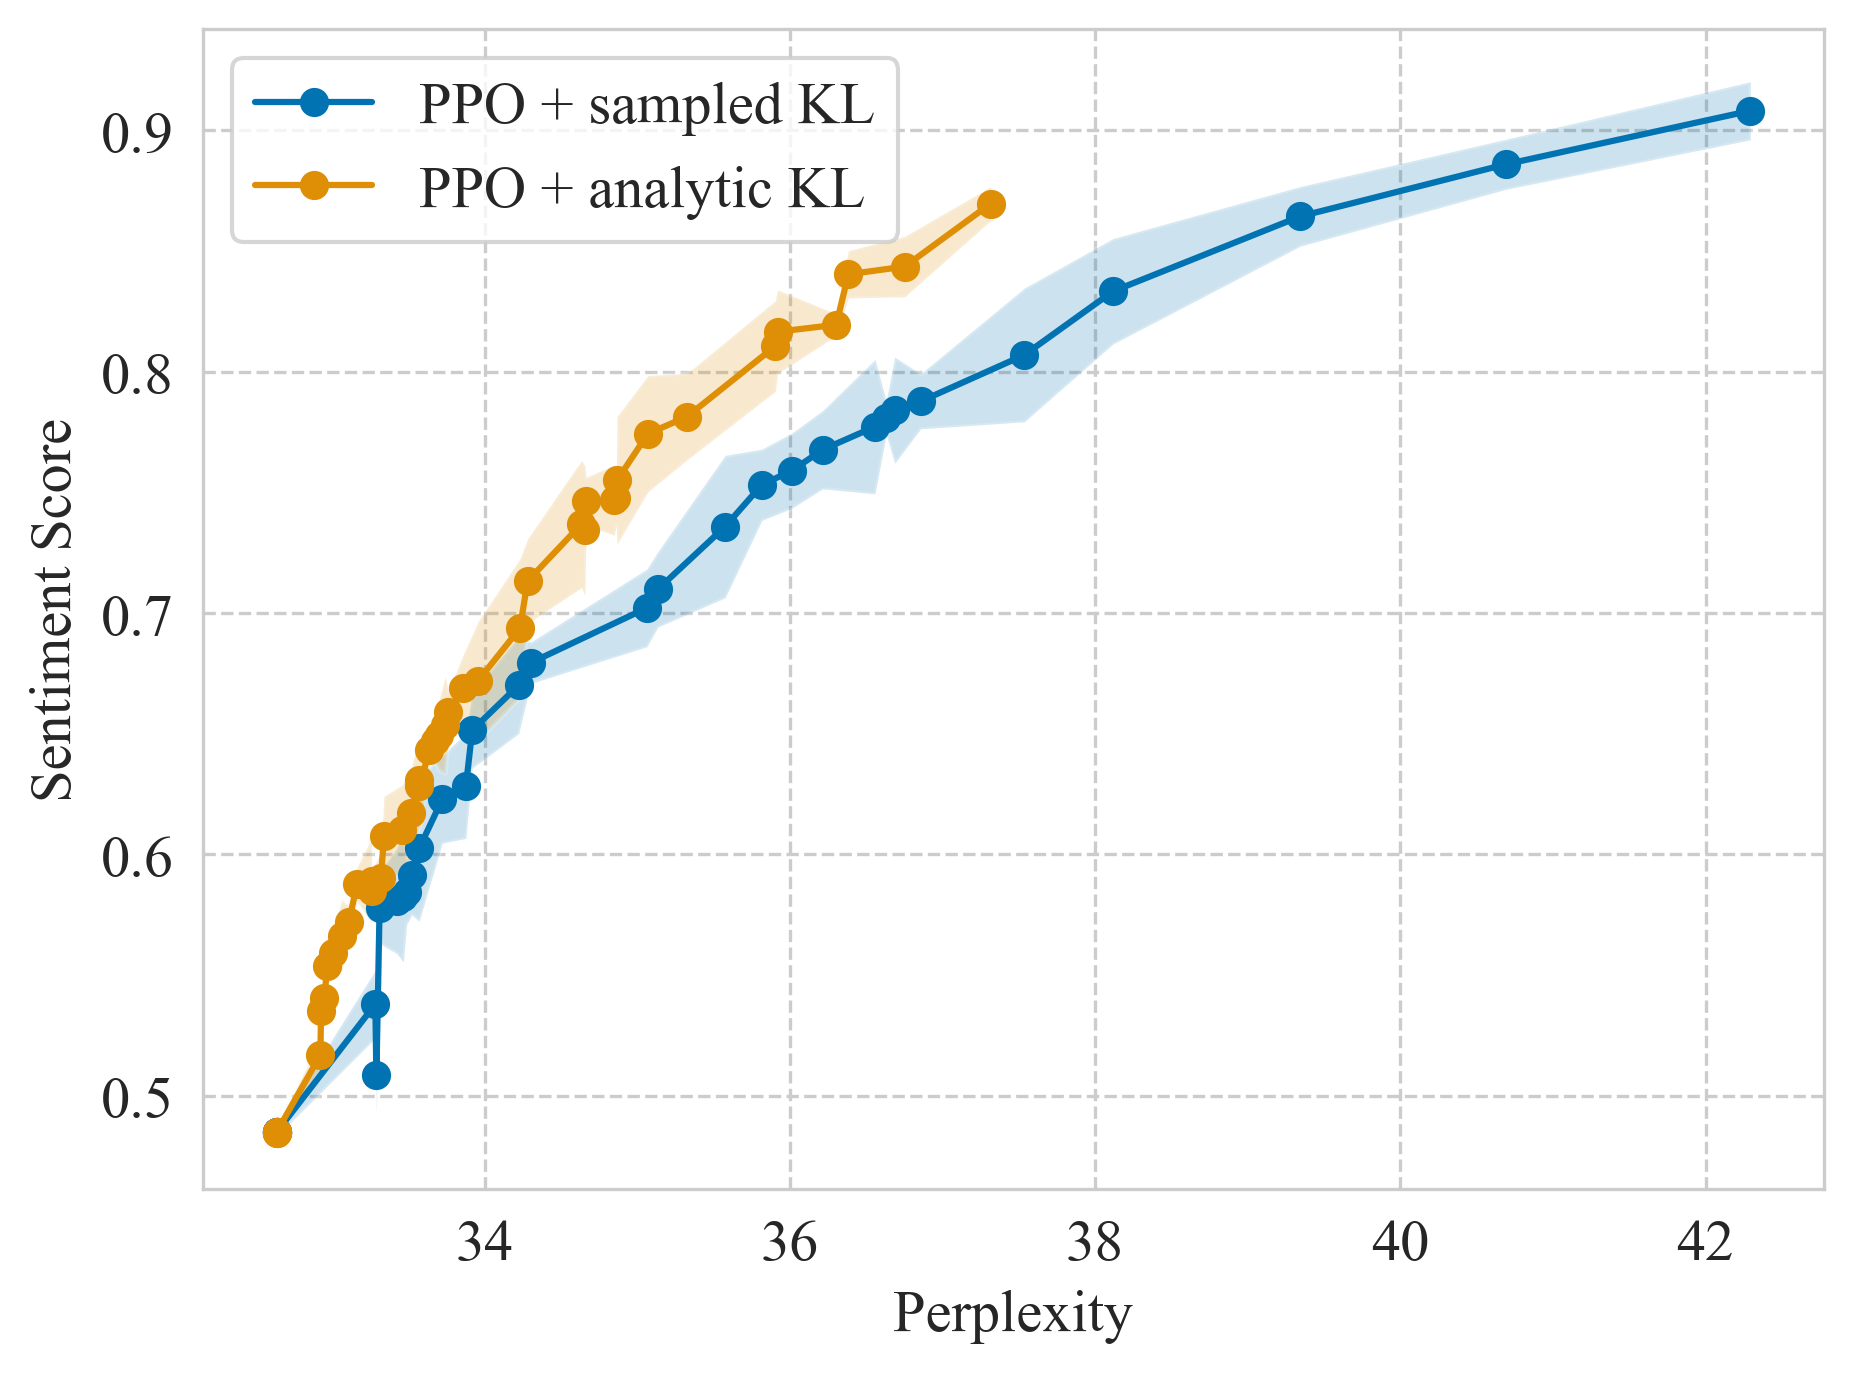

In [74]:
# print(agg_score)
# COLORS = {'SAC + ensemble + resets': 'C3', 'SAC + WD': 'C2', 'SAC + resets': 'C1', 'SAC': 'C0'}
def group_label_to_plot_label(group_label):
    # return f'AG={group_label[0]},AR={group_label[1]}'
    if group_label == (True, True):
        # return 'PPO + analytic KL grad + analytic KL reward'
        return 'PPO + analytic KL'
    elif group_label == (False, False):
        return 'PPO + sampled KL'


ncols = 1
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.4 * ncols, 4.8 * nrows), sharey=True, squeeze=False)
ax = axes[0][0]

perplexity_threshold = 100

pareto_front_filtered = pareto_front[pareto_front['mean']['test/fluency_metrics/perplexity'] < perplexity_threshold]

for group_label, group in pareto_front_filtered.groupby(level=['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward']):
    if group_label not in [(True, True), (False, False)]:
        continue
    plot_label = group_label_to_plot_label(group_label)
    split = 'test'
    group = group.sort_values(('mean', f'{split}/fluency_metrics/perplexity'))
    y = group['mean'][f'{split}/semantic/learned_automodel_metric']
    yerr = group['std'][f'{split}/semantic/learned_automodel_metric']
    x = group['mean'][f'{split}/fluency_metrics/perplexity']
    xerr = group['std'][f'{split}/fluency_metrics/perplexity']
    # print(group.shape, group['std'].shape, group['std']['test/semantic/learned_automodel_metric'].shape)
    # print(plot_label, x.shape, y.shape)
    # ax.set_xlim(33, 34)
    # ax.errorbar(x, y, yerr=yerr, marker='', label=plot_label)
    ax.plot(x, y, marker='o', label=plot_label)
    # print(x.shape, y.shape, yerr.shape)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
    ax.set_xlabel('Perplexity')
    ax.set_ylabel('Sentiment Score')
                      
ax.legend()
fig.tight_layout()

# fig, axes = plot_utils.plot_interval_estimates(
#   agg_score_sac_wd_agg, agg_score_cis_sac_wd_agg,
#   # metric_names=['IQM', 'Median', 'Mean'],
#       metric_names=[''],
#   # algorithms=['DrQ + resets, 100K', 'Ours, 100K', 'DrQ + resets, 1M', 'Ours, 1M',], xlabel='IQM',
#     # algorithms=['SAC + ensemble, $N=1$', 'SAC| + ensemble, $N=5$', 'SAC + ensemble, $N=10$', 'SAC + ensemble, $N=20$', ], xlabel='IQM',
#         # algorithms=['SAC + ens. ($N=1$)', 'SAC + ens. ($N=5$)', 'SAC + ens. ($N=10$)', 'SAC + ens. ($N=20$)', ], xlabel='IQM',
#         # colors=COLORS,
#             algorithms=labels, xlabel='IQM',
#     # algorithms=['DrQ, 100K', 'DrQ + resets, 100K', 'Ours, n=10, 100K', 'DrQ, 1M', 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#     # algorithms=[ 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#   row_height=0.7
# )
# # print(agg_score)
# # axes.set_title('SAC + ensemble', fontsize='xx-large')
# # fig.tight_layout()
FIGURE_DIR = Path('/Users/lin/Documents/Courses/UdeM/IFT6289/project/figures/')
os.makedirs(FIGURE_DIR, exist_ok=True)
BASE_NAME = 'pareto_main_test'
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.png', bbox_inches="tight")
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.pdf', bbox_inches="tight")

### Validation (ablation)

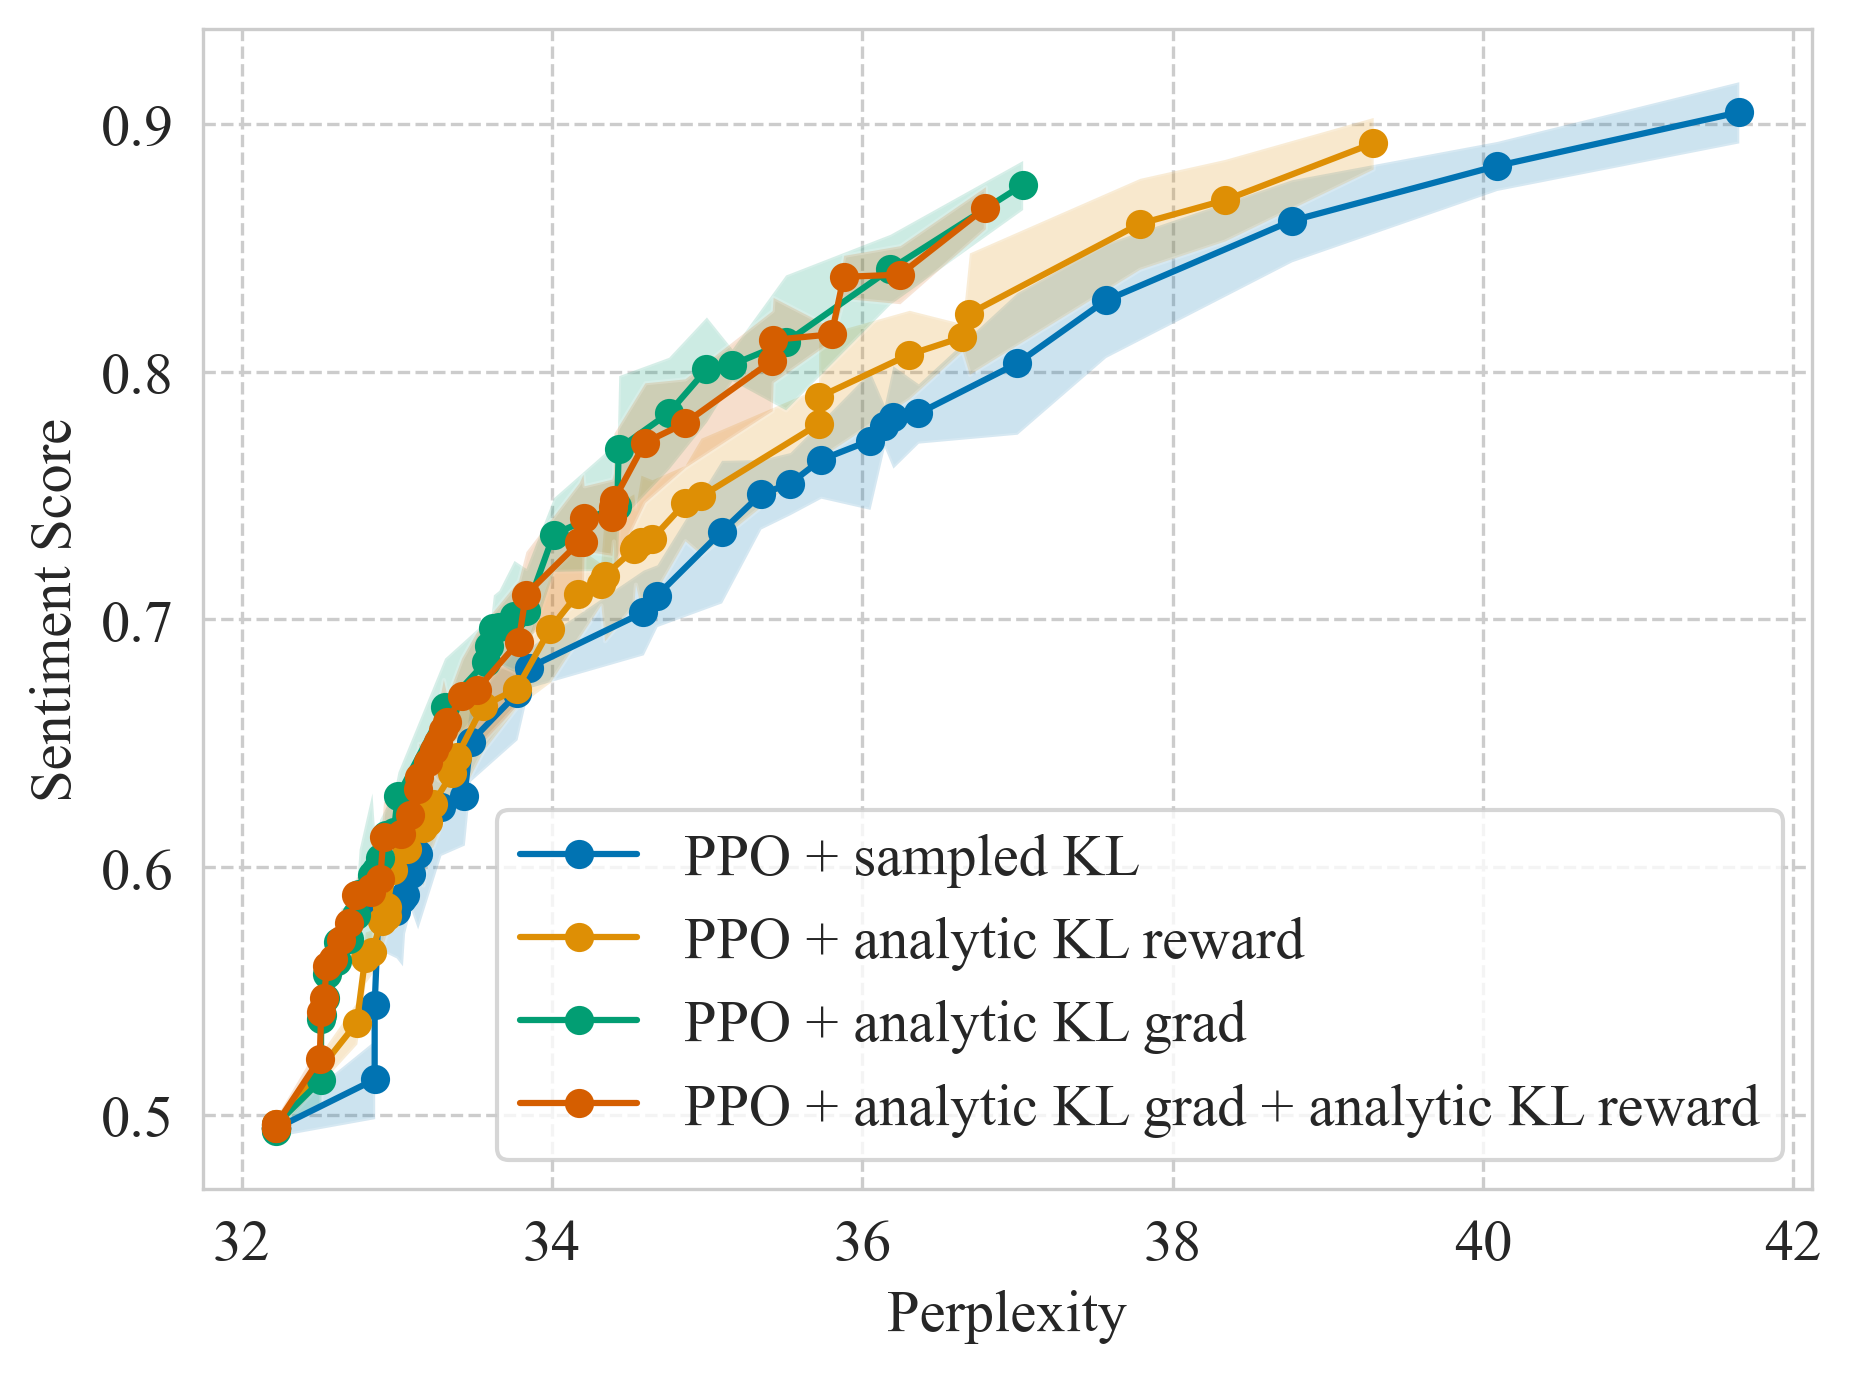

In [72]:
# print(agg_score)
# COLORS = {'SAC + ensemble + resets': 'C3', 'SAC + WD': 'C2', 'SAC + resets': 'C1', 'SAC': 'C0'}
def group_label_to_plot_label(group_label):
    # return f'AG={group_label[0]},AR={group_label[1]}'
    if group_label == (True, True):
        return 'PPO + analytic KL grad + analytic KL reward'
    elif group_label == (True, False):
        return 'PPO + analytic KL grad'
    elif group_label == (False, True):
        return 'PPO + analytic KL reward'
    elif group_label == (False, False):
        return 'PPO + sampled KL'


ncols = 1
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.4 * ncols, 4.8 * nrows), sharey=True, squeeze=False)
ax = axes[0][0]

perplexity_threshold = 100

pareto_front_filtered = pareto_front[pareto_front['mean']['test/fluency_metrics/perplexity'] < perplexity_threshold]

for group_label, group in pareto_front_filtered.groupby(level=['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward']):
    # if group_label not in [(True, True), (False, False)]:
        # continue
    plot_label = group_label_to_plot_label(group_label)
    split = 'val'
    group = group.sort_values(('mean', f'{split}/fluency_metrics/perplexity'))
    y = group['mean'][f'{split}/semantic/learned_automodel_metric']
    yerr = group['std'][f'{split}/semantic/learned_automodel_metric']
    x = group['mean'][f'{split}/fluency_metrics/perplexity']
    xerr = group['std'][f'{split}/fluency_metrics/perplexity']
    # print(group.shape, group['std'].shape, group['std']['test/semantic/learned_automodel_metric'].shape)
    # print(plot_label, x.shape, y.shape)
    # ax.set_xlim(33, 34)
    # ax.errorbar(x, y, yerr=yerr, marker='', label=plot_label)
    ax.plot(x, y, marker='o', label=plot_label)
    # print(x.shape, y.shape, yerr.shape)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
    ax.set_xlabel('Perplexity')
    ax.set_ylabel('Sentiment Score')
                      
ax.legend()
fig.tight_layout()

# fig, axes = plot_utils.plot_interval_estimates(
#   agg_score_sac_wd_agg, agg_score_cis_sac_wd_agg,
#   # metric_names=['IQM', 'Median', 'Mean'],
#       metric_names=[''],
#   # algorithms=['DrQ + resets, 100K', 'Ours, 100K', 'DrQ + resets, 1M', 'Ours, 1M',], xlabel='IQM',
#     # algorithms=['SAC + ensemble, $N=1$', 'SAC| + ensemble, $N=5$', 'SAC + ensemble, $N=10$', 'SAC + ensemble, $N=20$', ], xlabel='IQM',
#         # algorithms=['SAC + ens. ($N=1$)', 'SAC + ens. ($N=5$)', 'SAC + ens. ($N=10$)', 'SAC + ens. ($N=20$)', ], xlabel='IQM',
#         # colors=COLORS,
#             algorithms=labels, xlabel='IQM',
#     # algorithms=['DrQ, 100K', 'DrQ + resets, 100K', 'Ours, n=10, 100K', 'DrQ, 1M', 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#     # algorithms=[ 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#   row_height=0.7
# )
# # print(agg_score)
# # axes.set_title('SAC + ensemble', fontsize='xx-large')
# # fig.tight_layout()
FIGURE_DIR = Path('/Users/lin/Documents/Courses/UdeM/IFT6289/project/figures/')
os.makedirs(FIGURE_DIR, exist_ok=True)
BASE_NAME = f'pareto_ablate_{split}'
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.png', bbox_inches="tight")
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.pdf', bbox_inches="tight")

###  Test (ablation)

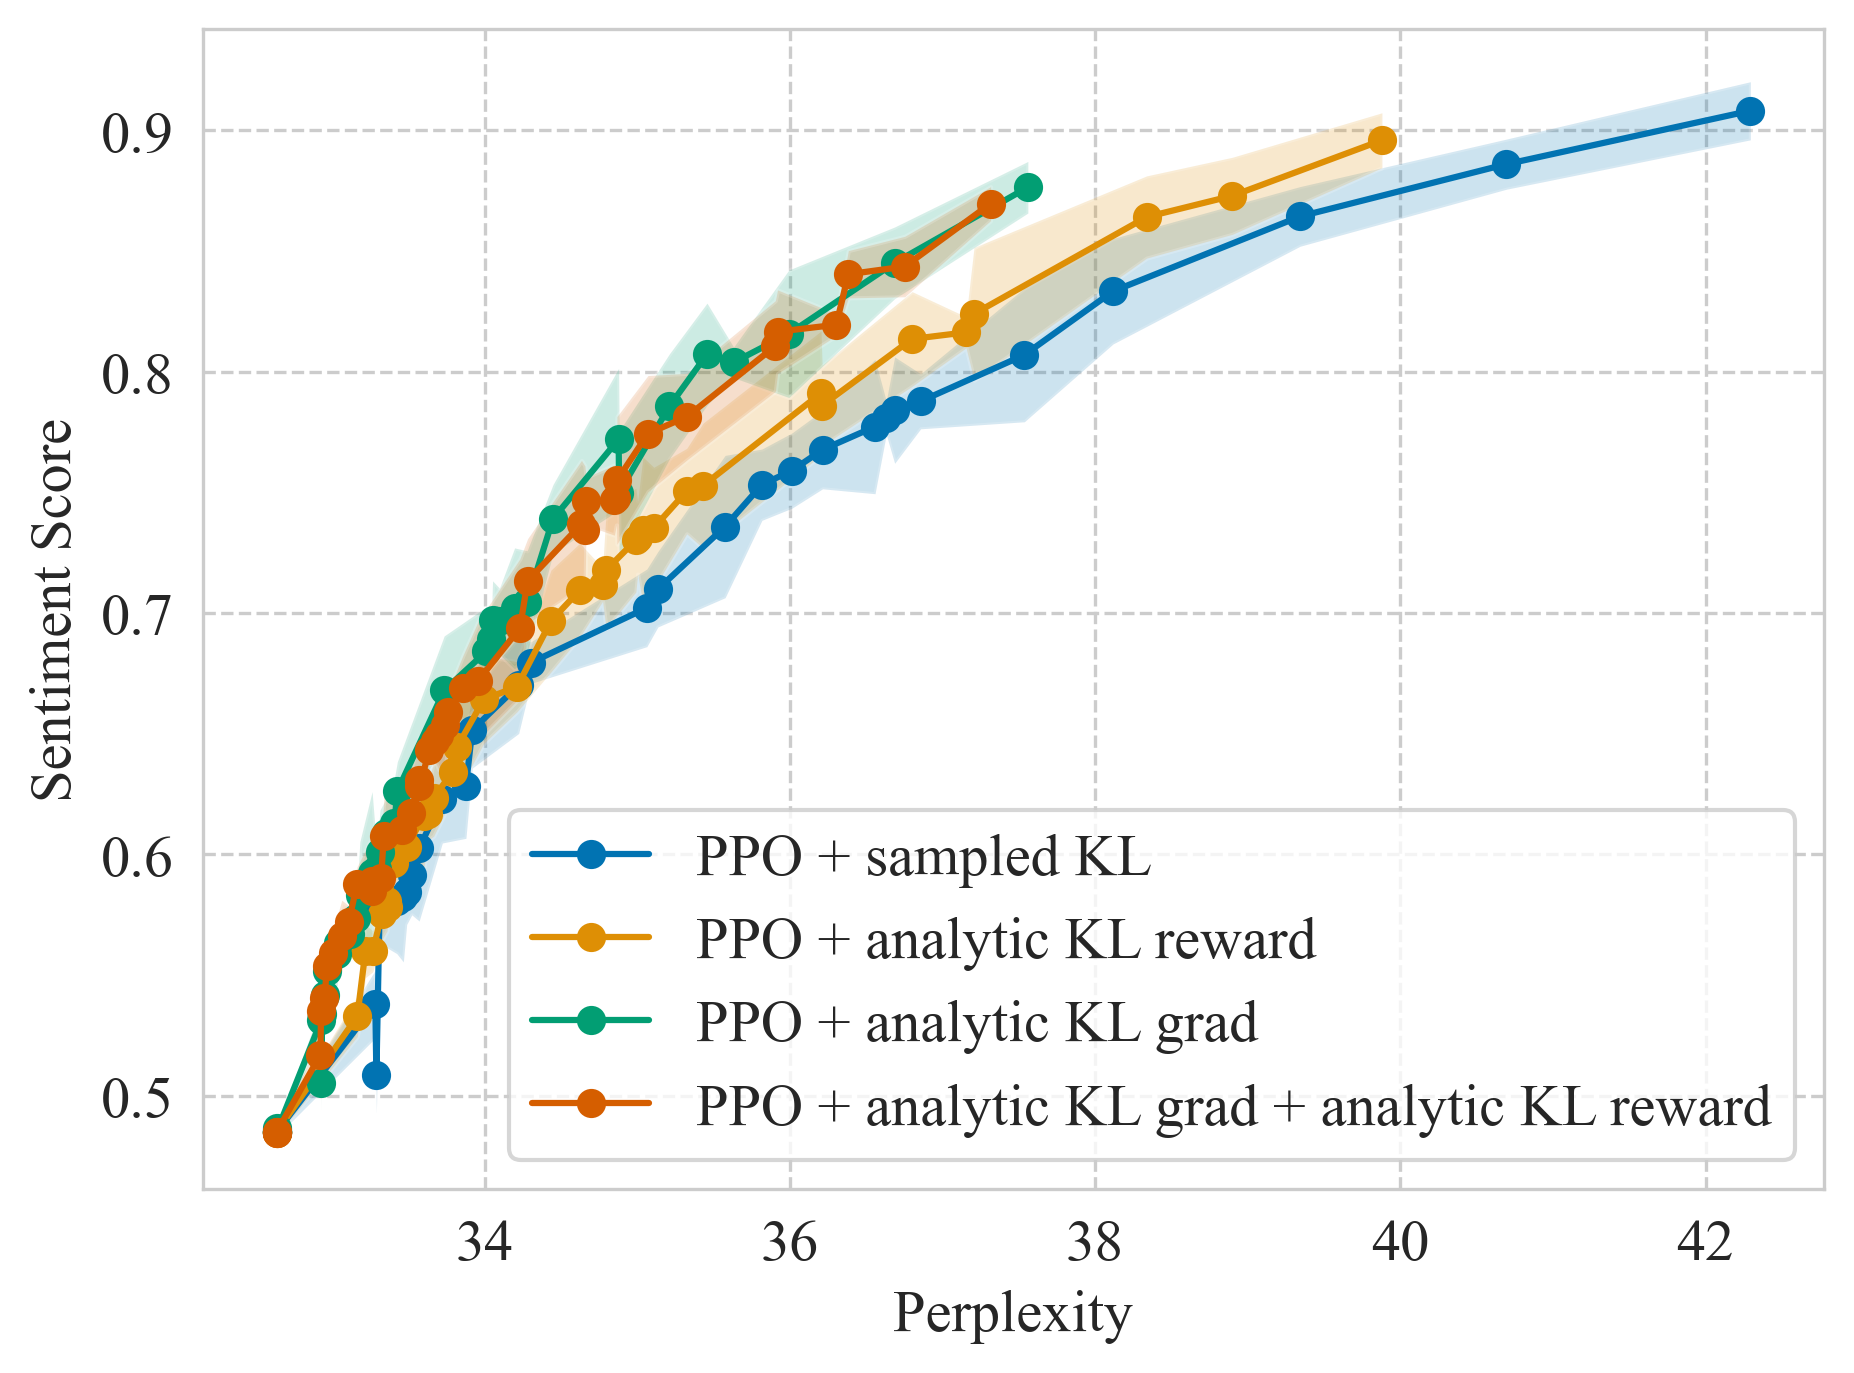

In [73]:
# print(agg_score)
# COLORS = {'SAC + ensemble + resets': 'C3', 'SAC + WD': 'C2', 'SAC + resets': 'C1', 'SAC': 'C0'}
def group_label_to_plot_label(group_label):
    # return f'AG={group_label[0]},AR={group_label[1]}'
    if group_label == (True, True):
        return 'PPO + analytic KL grad + analytic KL reward'
    elif group_label == (True, False):
        return 'PPO + analytic KL grad'
    elif group_label == (False, True):
        return 'PPO + analytic KL reward'
    elif group_label == (False, False):
        return 'PPO + sampled KL'


ncols = 1
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.4 * ncols, 4.8 * nrows), sharey=True, squeeze=False)
ax = axes[0][0]

perplexity_threshold = 100

pareto_front_filtered = pareto_front[pareto_front['mean']['test/fluency_metrics/perplexity'] < perplexity_threshold]

for group_label, group in pareto_front_filtered.groupby(level=['alg.args.analytic_kl_grad', 'alg.kl_div.analytic_kl_reward']):
    # if group_label not in [(True, True), (False, False)]:
        # continue
    plot_label = group_label_to_plot_label(group_label)
    split = 'test'
    group = group.sort_values(('mean', f'{split}/fluency_metrics/perplexity'))
    y = group['mean'][f'{split}/semantic/learned_automodel_metric']
    yerr = group['std'][f'{split}/semantic/learned_automodel_metric']
    x = group['mean'][f'{split}/fluency_metrics/perplexity']
    xerr = group['std'][f'{split}/fluency_metrics/perplexity']
    # print(group.shape, group['std'].shape, group['std']['test/semantic/learned_automodel_metric'].shape)
    # print(plot_label, x.shape, y.shape)
    # ax.set_xlim(33, 34)
    # ax.errorbar(x, y, yerr=yerr, marker='', label=plot_label)
    ax.plot(x, y, marker='o', label=plot_label)
    # print(x.shape, y.shape, yerr.shape)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
    ax.set_xlabel('Perplexity')
    ax.set_ylabel('Sentiment Score')
                      
ax.legend()
fig.tight_layout()

# fig, axes = plot_utils.plot_interval_estimates(
#   agg_score_sac_wd_agg, agg_score_cis_sac_wd_agg,
#   # metric_names=['IQM', 'Median', 'Mean'],
#       metric_names=[''],
#   # algorithms=['DrQ + resets, 100K', 'Ours, 100K', 'DrQ + resets, 1M', 'Ours, 1M',], xlabel='IQM',
#     # algorithms=['SAC + ensemble, $N=1$', 'SAC| + ensemble, $N=5$', 'SAC + ensemble, $N=10$', 'SAC + ensemble, $N=20$', ], xlabel='IQM',
#         # algorithms=['SAC + ens. ($N=1$)', 'SAC + ens. ($N=5$)', 'SAC + ens. ($N=10$)', 'SAC + ens. ($N=20$)', ], xlabel='IQM',
#         # colors=COLORS,
#             algorithms=labels, xlabel='IQM',
#     # algorithms=['DrQ, 100K', 'DrQ + resets, 100K', 'Ours, n=10, 100K', 'DrQ, 1M', 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#     # algorithms=[ 'DrQ + resets, 1M', 'Ours, n=10, 1M',], xlabel='IQM',
#   row_height=0.7
# )
# # print(agg_score)
# # axes.set_title('SAC + ensemble', fontsize='xx-large')
# # fig.tight_layout()
FIGURE_DIR = Path('/Users/lin/Documents/Courses/UdeM/IFT6289/project/figures/')
os.makedirs(FIGURE_DIR, exist_ok=True)
BASE_NAME = f'pareto_ablate_{split}'
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.png', bbox_inches="tight")
plt.savefig(FIGURE_DIR / f'{BASE_NAME}.pdf', bbox_inches="tight")

### Compute score